In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
# Python SQLalchemy

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:

engine = create_engine("sqlite:///hawaii.sqlite")

In [12]:
# modeling DB
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [13]:
# TB references
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
#Link from python to DB
session = Session(engine)


/Users/prmis/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  if sys.path[0] == '':


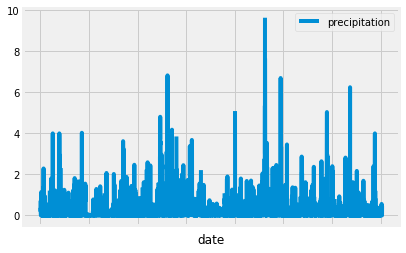

In [19]:
# calculate the date 2 years from the date in data set.
prev_years = dt.date(2016, 8, 23) - dt.timedelta(days=730)

# retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_years).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x_compat=True)

In [20]:
# dataframe

df.describe()

,precipitation
count,6347.000000
mean,0.184723
std,0.483054
min,0.000000
25%,0.000000
50%,0.020000
75%,0.140000
max,9.640000


In [21]:
session.query(func.count(Station.station)).all()

[(9)]

In [23]:
# List the stations and the counts 
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

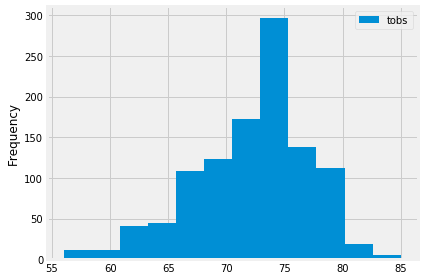

In [27]:
# Choose the station with the highest number of temperature observations
import datetime as dt
from pandas.plotting import table
prev_years = dt.date(2016, 8, 23) - dt.timedelta(days=730)

analysis = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_years).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()

In [31]:

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2016-01-20', '2017-08-21'))

[(56.0, 74.27814938684504, 87.0)]


In [36]:
import datetime as dt

prev_year_start = dt.date(2018, 1, 31) - dt.timedelta(days=730)
prev_year_end = dt.date(2018, 2, 15) - dt.timedelta(days=730)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

56.0 69.57281553398059 79.0


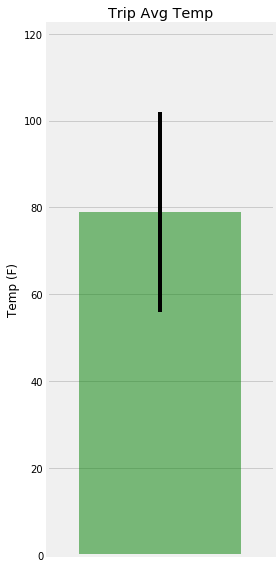

In [38]:
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='green', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

In [41]:
start_date = '2012-01-311'
end_date = '2012-02-15'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.5), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.35), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.15), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.8400000000000001), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.84), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.8), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.7100000000000001), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.44000000000000006), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.0)]
